## Q-Learning for MountainCar (using a Neural Network)

In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import gym
import matplotlib.pyplot as plt
%matplotlib inline

Number of possible actions: 3
Number of possible states: Box(2,)


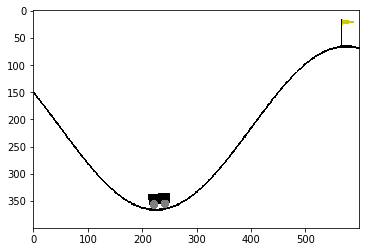

In [18]:
env = gym.make("MountainCar-v0").env

print("Number of possible actions:", env.action_space.n)
print("Number of possible states:", env.observation_space)

env.reset()
plt.imshow(env.render("rgb_array"))

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [20]:
class qAgent:
    def __init__(self, n_action_space, n_observation_space, epsilon, alpha, discount_factor):
        self.n_action_space = n_action_space
        self.n_observation_space = n_observation_space
        
        self.epsilon = epsilon
        self.alpha = alpha
        self.discount_factor = discount_factor
        
        self.qnetwork = nn.Sequential(
                    nn.Linear(n_observation_space[0], 128),
                    nn.ReLU(),
                    nn.Linear(128, 256),
                    nn.ReLU(),
                    nn.Linear(256, n_action_space)
        ).to(device)
        
    def get_action_epsilon_greedy(self, state):    
        # the action returned either will be random or the greedy
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.n_action_space) # return a random action
        else: # else, be greedy
            state = torch.tensor(state, dtype=torch.float32, device=device)
            qvalues = self.qnetwork(state).detach() # returns a new Tensor, detached from the current graph.
            action = torch.argmax(qvalues).item() 
        return action
    
    def get_greedy_action(self, state):
        state = torch.tensor(state, dtype=torch.float32, device=device)
        qvalues = self.qnetwork(state).detach() # returns a new Tensor, detached from the current graph.
        action = torch.argmax(qvalues).item() 
        return action
    
    def get_qvalues(self, state):
        return self.qnetwork(state)
   
    def calculate_loss(self, state, action, new_state, reward, done):
        # convert variables to tensor
        state = torch.tensor(state, dtype=torch.float32, device=device)
        new_state = torch.tensor(new_state, dtype=torch.float32, device=device)
        reward = torch.tensor(reward, dtype=torch.float32, device=device)
        not_done = 1 - done

        # predict all q-values for current state
        all_qvalues_state = self.get_qvalues(state)
       
        # select the q_value for the agent action
        qvalue_state = all_qvalues_state[action]
        
        # predict all q-values for the new state 
        all_qvalues_new_state = self.get_qvalues(new_state)
       
        # index of action that maximizes the new state q(s,a)
        argmax_new_action = torch.argmax(all_qvalues_new_state)
        # select the q-value for the new state for the action that maximises it, q'(s',amax)
        qvalue_new_state =  all_qvalues_new_state[argmax_new_action]
        
 
        # if it's a terminal state (done) the target receives only the value of the reward
        max_qvalue_new_state = reward + self.discount_factor*qvalue_new_state*not_done

        # loss = MSE (mean squared error) between Q-network and Q-learning targets
        # the detach is a way to fix the network by not having their gradients computed
        loss = F.mse_loss(max_qvalue_new_state.detach(), qvalue_state)
        
        return loss

In [21]:
# hyperparameters
epsilon_init = 0.8
epsilon_end = 0.1

alpha = 0.5
discount_factor = 0.99

agent = qAgent(n_action_space=env.action_space.n,
               n_observation_space=env.observation_space.shape,
               epsilon=epsilon_init,
               alpha=alpha,
               discount_factor=discount_factor)


In [22]:
learning_rate = 0.0001
optimiser = torch.optim.Adam(agent.qnetwork.parameters(), lr=learning_rate)

In [23]:
def train(env, n_epochs=1000, reward_position=False):
    rewards_history = []
    positions_history = []
    score = []
    
    # constant to decrement the value of epsilon
    epsilon_decrement = (epsilon_init - epsilon_end)/n_epochs
    
    for epoch in range(n_epochs):
        positions_episode = []

        rewards_episode = 0
        state = env.reset()
        done = False
        for _ in range(2000):
            action = agent.get_action_epsilon_greedy(state)

            new_state, reward, done, info = env.step(action)
            
            rewards_episode += reward
            position = new_state[0] + 0.5
            positions_episode.append(position)

            if reward_position: # use position-reward instead of reward?
                loss = agent.calculate_loss(state, action, new_state, position, done)
            else:
                loss = agent.calculate_loss(state, action, new_state, reward, done)
                
            loss.backward()
            optimiser.step()
            optimiser.zero_grad()

            state = new_state
            if done:
                if position >= env.goal_position: # arrived at the position goal?
                    score.append(1)
                    break
                else:
                    score.append(0)

        print("Epoch={} \t epsilon={:.2f}\t score={}/{}\t rewards={:.2f}".format(epoch+1, agent.epsilon, score.count(1), len(score), rewards_episode))
        rewards_history.append(rewards_episode)
        positions_history.append(positions_episode)
        
        agent.epsilon -= epsilon_decrement
            
    return rewards_history, score

Epoch=1 	 epsilon=0.80	 score=0\0	 rewards=-2000.00
Epoch=2 	 epsilon=0.80	 score=0\0	 rewards=-2000.00
Epoch=3 	 epsilon=0.80	 score=0\0	 rewards=-2000.00
Epoch=4 	 epsilon=0.80	 score=0\0	 rewards=-2000.00
Epoch=5 	 epsilon=0.80	 score=1\1	 rewards=-1931.00
Epoch=6 	 epsilon=0.80	 score=1\1	 rewards=-2000.00
Epoch=7 	 epsilon=0.80	 score=1\1	 rewards=-2000.00
Epoch=8 	 epsilon=0.80	 score=1\1	 rewards=-2000.00
Epoch=9 	 epsilon=0.80	 score=1\1	 rewards=-2000.00
Epoch=10 	 epsilon=0.80	 score=1\1	 rewards=-2000.00
Epoch=11 	 epsilon=0.80	 score=1\1	 rewards=-2000.00
Epoch=12 	 epsilon=0.80	 score=1\1	 rewards=-2000.00
Epoch=13 	 epsilon=0.80	 score=1\1	 rewards=-2000.00
Epoch=14 	 epsilon=0.80	 score=1\1	 rewards=-2000.00
Epoch=15 	 epsilon=0.80	 score=1\1	 rewards=-2000.00
Epoch=16 	 epsilon=0.79	 score=1\1	 rewards=-2000.00
Epoch=17 	 epsilon=0.79	 score=1\1	 rewards=-2000.00
Epoch=18 	 epsilon=0.79	 score=1\1	 rewards=-2000.00
Epoch=19 	 epsilon=0.79	 score=1\1	 rewards=-2000.00
Ep

Epoch=155 	 epsilon=0.75	 score=3\3	 rewards=-2000.00
Epoch=156 	 epsilon=0.75	 score=3\3	 rewards=-2000.00
Epoch=157 	 epsilon=0.75	 score=3\3	 rewards=-2000.00
Epoch=158 	 epsilon=0.75	 score=3\3	 rewards=-2000.00
Epoch=159 	 epsilon=0.74	 score=3\3	 rewards=-2000.00
Epoch=160 	 epsilon=0.74	 score=3\3	 rewards=-2000.00
Epoch=161 	 epsilon=0.74	 score=3\3	 rewards=-2000.00
Epoch=162 	 epsilon=0.74	 score=3\3	 rewards=-2000.00
Epoch=163 	 epsilon=0.74	 score=3\3	 rewards=-2000.00
Epoch=164 	 epsilon=0.74	 score=3\3	 rewards=-2000.00
Epoch=165 	 epsilon=0.74	 score=3\3	 rewards=-2000.00
Epoch=166 	 epsilon=0.74	 score=3\3	 rewards=-2000.00
Epoch=167 	 epsilon=0.74	 score=3\3	 rewards=-2000.00
Epoch=168 	 epsilon=0.74	 score=3\3	 rewards=-2000.00
Epoch=169 	 epsilon=0.74	 score=3\3	 rewards=-2000.00
Epoch=170 	 epsilon=0.74	 score=3\3	 rewards=-2000.00
Epoch=171 	 epsilon=0.74	 score=3\3	 rewards=-2000.00
Epoch=172 	 epsilon=0.74	 score=3\3	 rewards=-2000.00
Epoch=173 	 epsilon=0.74	 sc

Epoch=306 	 epsilon=0.69	 score=45\45	 rewards=-869.00
Epoch=307 	 epsilon=0.69	 score=46\46	 rewards=-666.00
Epoch=308 	 epsilon=0.69	 score=47\47	 rewards=-639.00
Epoch=309 	 epsilon=0.69	 score=48\48	 rewards=-930.00
Epoch=310 	 epsilon=0.69	 score=49\49	 rewards=-483.00
Epoch=311 	 epsilon=0.69	 score=50\50	 rewards=-856.00
Epoch=312 	 epsilon=0.69	 score=51\51	 rewards=-834.00
Epoch=313 	 epsilon=0.69	 score=52\52	 rewards=-784.00
Epoch=314 	 epsilon=0.69	 score=53\53	 rewards=-664.00
Epoch=315 	 epsilon=0.69	 score=54\54	 rewards=-795.00
Epoch=316 	 epsilon=0.69	 score=55\55	 rewards=-741.00
Epoch=317 	 epsilon=0.69	 score=56\56	 rewards=-549.00
Epoch=318 	 epsilon=0.69	 score=57\57	 rewards=-594.00
Epoch=319 	 epsilon=0.69	 score=57\57	 rewards=-2000.00
Epoch=320 	 epsilon=0.69	 score=58\58	 rewards=-736.00
Epoch=321 	 epsilon=0.69	 score=59\59	 rewards=-905.00
Epoch=322 	 epsilon=0.69	 score=60\60	 rewards=-1031.00
Epoch=323 	 epsilon=0.69	 score=61\61	 rewards=-601.00
Epoch=32

Epoch=452 	 epsilon=0.64	 score=189\189	 rewards=-584.00
Epoch=453 	 epsilon=0.64	 score=190\190	 rewards=-320.00
Epoch=454 	 epsilon=0.64	 score=191\191	 rewards=-373.00
Epoch=455 	 epsilon=0.64	 score=192\192	 rewards=-602.00
Epoch=456 	 epsilon=0.64	 score=193\193	 rewards=-586.00
Epoch=457 	 epsilon=0.64	 score=194\194	 rewards=-527.00
Epoch=458 	 epsilon=0.64	 score=195\195	 rewards=-983.00
Epoch=459 	 epsilon=0.64	 score=196\196	 rewards=-1136.00
Epoch=460 	 epsilon=0.64	 score=197\197	 rewards=-955.00
Epoch=461 	 epsilon=0.64	 score=198\198	 rewards=-796.00
Epoch=462 	 epsilon=0.64	 score=199\199	 rewards=-587.00
Epoch=463 	 epsilon=0.64	 score=200\200	 rewards=-465.00
Epoch=464 	 epsilon=0.64	 score=201\201	 rewards=-713.00
Epoch=465 	 epsilon=0.64	 score=202\202	 rewards=-961.00
Epoch=466 	 epsilon=0.64	 score=203\203	 rewards=-468.00
Epoch=467 	 epsilon=0.64	 score=204\204	 rewards=-347.00
Epoch=468 	 epsilon=0.64	 score=205\205	 rewards=-426.00
Epoch=469 	 epsilon=0.64	 scor

Epoch=596 	 epsilon=0.59	 score=333\333	 rewards=-244.00
Epoch=597 	 epsilon=0.59	 score=334\334	 rewards=-419.00
Epoch=598 	 epsilon=0.59	 score=335\335	 rewards=-225.00
Epoch=599 	 epsilon=0.59	 score=336\336	 rewards=-454.00
Epoch=600 	 epsilon=0.59	 score=337\337	 rewards=-580.00
Epoch=601 	 epsilon=0.59	 score=338\338	 rewards=-370.00
Epoch=602 	 epsilon=0.59	 score=339\339	 rewards=-220.00
Epoch=603 	 epsilon=0.59	 score=340\340	 rewards=-290.00
Epoch=604 	 epsilon=0.59	 score=341\341	 rewards=-254.00
Epoch=605 	 epsilon=0.59	 score=342\342	 rewards=-248.00
Epoch=606 	 epsilon=0.59	 score=343\343	 rewards=-381.00
Epoch=607 	 epsilon=0.59	 score=344\344	 rewards=-198.00
Epoch=608 	 epsilon=0.59	 score=345\345	 rewards=-374.00
Epoch=609 	 epsilon=0.59	 score=346\346	 rewards=-367.00
Epoch=610 	 epsilon=0.59	 score=347\347	 rewards=-274.00
Epoch=611 	 epsilon=0.59	 score=348\348	 rewards=-462.00
Epoch=612 	 epsilon=0.59	 score=349\349	 rewards=-267.00
Epoch=613 	 epsilon=0.59	 score

Epoch=740 	 epsilon=0.54	 score=477\477	 rewards=-368.00
Epoch=741 	 epsilon=0.54	 score=478\478	 rewards=-410.00
Epoch=742 	 epsilon=0.54	 score=479\479	 rewards=-292.00
Epoch=743 	 epsilon=0.54	 score=480\480	 rewards=-231.00
Epoch=744 	 epsilon=0.54	 score=481\481	 rewards=-287.00
Epoch=745 	 epsilon=0.54	 score=482\482	 rewards=-326.00
Epoch=746 	 epsilon=0.54	 score=483\483	 rewards=-278.00
Epoch=747 	 epsilon=0.54	 score=484\484	 rewards=-416.00
Epoch=748 	 epsilon=0.54	 score=485\485	 rewards=-302.00
Epoch=749 	 epsilon=0.54	 score=486\486	 rewards=-415.00
Epoch=750 	 epsilon=0.54	 score=487\487	 rewards=-377.00
Epoch=751 	 epsilon=0.54	 score=488\488	 rewards=-356.00
Epoch=752 	 epsilon=0.54	 score=489\489	 rewards=-304.00
Epoch=753 	 epsilon=0.54	 score=490\490	 rewards=-282.00
Epoch=754 	 epsilon=0.54	 score=491\491	 rewards=-296.00
Epoch=755 	 epsilon=0.54	 score=492\492	 rewards=-313.00
Epoch=756 	 epsilon=0.54	 score=493\493	 rewards=-295.00
Epoch=757 	 epsilon=0.54	 score

Epoch=884 	 epsilon=0.49	 score=621\621	 rewards=-279.00
Epoch=885 	 epsilon=0.49	 score=622\622	 rewards=-231.00
Epoch=886 	 epsilon=0.49	 score=623\623	 rewards=-328.00
Epoch=887 	 epsilon=0.49	 score=624\624	 rewards=-278.00
Epoch=888 	 epsilon=0.49	 score=625\625	 rewards=-490.00
Epoch=889 	 epsilon=0.49	 score=626\626	 rewards=-407.00
Epoch=890 	 epsilon=0.49	 score=627\627	 rewards=-1769.00
Epoch=891 	 epsilon=0.49	 score=628\628	 rewards=-414.00
Epoch=892 	 epsilon=0.49	 score=629\629	 rewards=-267.00
Epoch=893 	 epsilon=0.49	 score=630\630	 rewards=-434.00
Epoch=894 	 epsilon=0.49	 score=631\631	 rewards=-624.00
Epoch=895 	 epsilon=0.49	 score=632\632	 rewards=-613.00
Epoch=896 	 epsilon=0.49	 score=633\633	 rewards=-291.00
Epoch=897 	 epsilon=0.49	 score=634\634	 rewards=-230.00
Epoch=898 	 epsilon=0.49	 score=635\635	 rewards=-307.00
Epoch=899 	 epsilon=0.49	 score=636\636	 rewards=-303.00
Epoch=900 	 epsilon=0.49	 score=637\637	 rewards=-334.00
Epoch=901 	 epsilon=0.49	 scor

Epoch=1028 	 epsilon=0.44	 score=765\765	 rewards=-162.00
Epoch=1029 	 epsilon=0.44	 score=766\766	 rewards=-155.00
Epoch=1030 	 epsilon=0.44	 score=767\767	 rewards=-160.00
Epoch=1031 	 epsilon=0.44	 score=768\768	 rewards=-251.00
Epoch=1032 	 epsilon=0.44	 score=769\769	 rewards=-216.00
Epoch=1033 	 epsilon=0.44	 score=770\770	 rewards=-239.00
Epoch=1034 	 epsilon=0.44	 score=771\771	 rewards=-216.00
Epoch=1035 	 epsilon=0.44	 score=772\772	 rewards=-251.00
Epoch=1036 	 epsilon=0.44	 score=773\773	 rewards=-215.00
Epoch=1037 	 epsilon=0.44	 score=774\774	 rewards=-174.00
Epoch=1038 	 epsilon=0.44	 score=775\775	 rewards=-158.00
Epoch=1039 	 epsilon=0.44	 score=776\776	 rewards=-154.00
Epoch=1040 	 epsilon=0.44	 score=777\777	 rewards=-234.00
Epoch=1041 	 epsilon=0.44	 score=778\778	 rewards=-328.00
Epoch=1042 	 epsilon=0.44	 score=779\779	 rewards=-191.00
Epoch=1043 	 epsilon=0.44	 score=780\780	 rewards=-238.00
Epoch=1044 	 epsilon=0.43	 score=781\781	 rewards=-239.00
Epoch=1045 	 e

Epoch=1170 	 epsilon=0.39	 score=907\907	 rewards=-188.00
Epoch=1171 	 epsilon=0.39	 score=908\908	 rewards=-179.00
Epoch=1172 	 epsilon=0.39	 score=909\909	 rewards=-193.00
Epoch=1173 	 epsilon=0.39	 score=910\910	 rewards=-151.00
Epoch=1174 	 epsilon=0.39	 score=911\911	 rewards=-157.00
Epoch=1175 	 epsilon=0.39	 score=912\912	 rewards=-195.00
Epoch=1176 	 epsilon=0.39	 score=913\913	 rewards=-159.00
Epoch=1177 	 epsilon=0.39	 score=914\914	 rewards=-176.00
Epoch=1178 	 epsilon=0.39	 score=915\915	 rewards=-135.00
Epoch=1179 	 epsilon=0.39	 score=916\916	 rewards=-188.00
Epoch=1180 	 epsilon=0.39	 score=917\917	 rewards=-201.00
Epoch=1181 	 epsilon=0.39	 score=918\918	 rewards=-190.00
Epoch=1182 	 epsilon=0.39	 score=919\919	 rewards=-194.00
Epoch=1183 	 epsilon=0.39	 score=920\920	 rewards=-146.00
Epoch=1184 	 epsilon=0.39	 score=921\921	 rewards=-155.00
Epoch=1185 	 epsilon=0.39	 score=922\922	 rewards=-162.00
Epoch=1186 	 epsilon=0.39	 score=923\923	 rewards=-199.00
Epoch=1187 	 e

Epoch=1310 	 epsilon=0.34	 score=1047\1047	 rewards=-122.00
Epoch=1311 	 epsilon=0.34	 score=1048\1048	 rewards=-127.00
Epoch=1312 	 epsilon=0.34	 score=1049\1049	 rewards=-192.00
Epoch=1313 	 epsilon=0.34	 score=1050\1050	 rewards=-191.00
Epoch=1314 	 epsilon=0.34	 score=1051\1051	 rewards=-114.00
Epoch=1315 	 epsilon=0.34	 score=1052\1052	 rewards=-159.00
Epoch=1316 	 epsilon=0.34	 score=1053\1053	 rewards=-157.00
Epoch=1317 	 epsilon=0.34	 score=1054\1054	 rewards=-149.00
Epoch=1318 	 epsilon=0.34	 score=1055\1055	 rewards=-160.00
Epoch=1319 	 epsilon=0.34	 score=1056\1056	 rewards=-180.00
Epoch=1320 	 epsilon=0.34	 score=1057\1057	 rewards=-155.00
Epoch=1321 	 epsilon=0.34	 score=1058\1058	 rewards=-190.00
Epoch=1322 	 epsilon=0.34	 score=1059\1059	 rewards=-156.00
Epoch=1323 	 epsilon=0.34	 score=1060\1060	 rewards=-149.00
Epoch=1324 	 epsilon=0.34	 score=1061\1061	 rewards=-174.00
Epoch=1325 	 epsilon=0.34	 score=1062\1062	 rewards=-185.00
Epoch=1326 	 epsilon=0.34	 score=1063\10

Epoch=1447 	 epsilon=0.29	 score=1184\1184	 rewards=-159.00
Epoch=1448 	 epsilon=0.29	 score=1185\1185	 rewards=-152.00
Epoch=1449 	 epsilon=0.29	 score=1186\1186	 rewards=-130.00
Epoch=1450 	 epsilon=0.29	 score=1187\1187	 rewards=-157.00
Epoch=1451 	 epsilon=0.29	 score=1188\1188	 rewards=-201.00
Epoch=1452 	 epsilon=0.29	 score=1189\1189	 rewards=-150.00
Epoch=1453 	 epsilon=0.29	 score=1190\1190	 rewards=-181.00
Epoch=1454 	 epsilon=0.29	 score=1191\1191	 rewards=-140.00
Epoch=1455 	 epsilon=0.29	 score=1192\1192	 rewards=-156.00
Epoch=1456 	 epsilon=0.29	 score=1193\1193	 rewards=-168.00
Epoch=1457 	 epsilon=0.29	 score=1194\1194	 rewards=-165.00
Epoch=1458 	 epsilon=0.29	 score=1195\1195	 rewards=-123.00
Epoch=1459 	 epsilon=0.29	 score=1196\1196	 rewards=-192.00
Epoch=1460 	 epsilon=0.29	 score=1197\1197	 rewards=-150.00
Epoch=1461 	 epsilon=0.29	 score=1198\1198	 rewards=-151.00
Epoch=1462 	 epsilon=0.29	 score=1199\1199	 rewards=-155.00
Epoch=1463 	 epsilon=0.29	 score=1200\12

Epoch=1584 	 epsilon=0.25	 score=1321\1321	 rewards=-120.00
Epoch=1585 	 epsilon=0.25	 score=1322\1322	 rewards=-153.00
Epoch=1586 	 epsilon=0.25	 score=1323\1323	 rewards=-154.00
Epoch=1587 	 epsilon=0.24	 score=1324\1324	 rewards=-153.00
Epoch=1588 	 epsilon=0.24	 score=1325\1325	 rewards=-150.00
Epoch=1589 	 epsilon=0.24	 score=1326\1326	 rewards=-154.00
Epoch=1590 	 epsilon=0.24	 score=1327\1327	 rewards=-166.00
Epoch=1591 	 epsilon=0.24	 score=1328\1328	 rewards=-152.00
Epoch=1592 	 epsilon=0.24	 score=1329\1329	 rewards=-149.00
Epoch=1593 	 epsilon=0.24	 score=1330\1330	 rewards=-134.00
Epoch=1594 	 epsilon=0.24	 score=1331\1331	 rewards=-117.00
Epoch=1595 	 epsilon=0.24	 score=1332\1332	 rewards=-155.00
Epoch=1596 	 epsilon=0.24	 score=1333\1333	 rewards=-154.00
Epoch=1597 	 epsilon=0.24	 score=1334\1334	 rewards=-153.00
Epoch=1598 	 epsilon=0.24	 score=1335\1335	 rewards=-149.00
Epoch=1599 	 epsilon=0.24	 score=1336\1336	 rewards=-167.00
Epoch=1600 	 epsilon=0.24	 score=1337\13

Epoch=1721 	 epsilon=0.20	 score=1458\1458	 rewards=-156.00
Epoch=1722 	 epsilon=0.20	 score=1459\1459	 rewards=-129.00
Epoch=1723 	 epsilon=0.20	 score=1460\1460	 rewards=-114.00
Epoch=1724 	 epsilon=0.20	 score=1461\1461	 rewards=-106.00
Epoch=1725 	 epsilon=0.20	 score=1462\1462	 rewards=-144.00
Epoch=1726 	 epsilon=0.20	 score=1463\1463	 rewards=-181.00
Epoch=1727 	 epsilon=0.20	 score=1464\1464	 rewards=-148.00
Epoch=1728 	 epsilon=0.20	 score=1465\1465	 rewards=-157.00
Epoch=1729 	 epsilon=0.20	 score=1466\1466	 rewards=-149.00
Epoch=1730 	 epsilon=0.19	 score=1467\1467	 rewards=-145.00
Epoch=1731 	 epsilon=0.19	 score=1468\1468	 rewards=-150.00
Epoch=1732 	 epsilon=0.19	 score=1469\1469	 rewards=-150.00
Epoch=1733 	 epsilon=0.19	 score=1470\1470	 rewards=-146.00
Epoch=1734 	 epsilon=0.19	 score=1471\1471	 rewards=-121.00
Epoch=1735 	 epsilon=0.19	 score=1472\1472	 rewards=-204.00
Epoch=1736 	 epsilon=0.19	 score=1473\1473	 rewards=-139.00
Epoch=1737 	 epsilon=0.19	 score=1474\14

Epoch=1858 	 epsilon=0.15	 score=1595\1595	 rewards=-157.00
Epoch=1859 	 epsilon=0.15	 score=1596\1596	 rewards=-148.00
Epoch=1860 	 epsilon=0.15	 score=1597\1597	 rewards=-163.00
Epoch=1861 	 epsilon=0.15	 score=1598\1598	 rewards=-144.00
Epoch=1862 	 epsilon=0.15	 score=1599\1599	 rewards=-110.00
Epoch=1863 	 epsilon=0.15	 score=1600\1600	 rewards=-149.00
Epoch=1864 	 epsilon=0.15	 score=1601\1601	 rewards=-114.00
Epoch=1865 	 epsilon=0.15	 score=1602\1602	 rewards=-115.00
Epoch=1866 	 epsilon=0.15	 score=1603\1603	 rewards=-115.00
Epoch=1867 	 epsilon=0.15	 score=1604\1604	 rewards=-119.00
Epoch=1868 	 epsilon=0.15	 score=1605\1605	 rewards=-114.00
Epoch=1869 	 epsilon=0.15	 score=1606\1606	 rewards=-117.00
Epoch=1870 	 epsilon=0.15	 score=1607\1607	 rewards=-182.00
Epoch=1871 	 epsilon=0.15	 score=1608\1608	 rewards=-115.00
Epoch=1872 	 epsilon=0.15	 score=1609\1609	 rewards=-142.00
Epoch=1873 	 epsilon=0.14	 score=1610\1610	 rewards=-114.00
Epoch=1874 	 epsilon=0.14	 score=1611\16

Epoch=1995 	 epsilon=0.10	 score=1732\1732	 rewards=-135.00
Epoch=1996 	 epsilon=0.10	 score=1733\1733	 rewards=-139.00
Epoch=1997 	 epsilon=0.10	 score=1734\1734	 rewards=-146.00
Epoch=1998 	 epsilon=0.10	 score=1735\1735	 rewards=-153.00
Epoch=1999 	 epsilon=0.10	 score=1736\1736	 rewards=-141.00
Epoch=2000 	 epsilon=0.10	 score=1737\1737	 rewards=-86.00


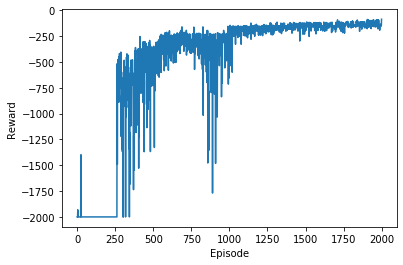

In [24]:
rewards, _ = train(env, n_epochs=2000)

plt.plot(rewards)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

In [28]:
# play some episodes to see how it's working 
from time import sleep

agent.qnetwork.eval() # set model to evaluation mode

for i in range(3):
    state = env.reset()
    done = False
    reward_sum = 0
    while not done:
        env.render()
        #state = torch.tensor(state, dtype=torch.float32, device=device)
        action = agent.get_greedy_action(state)
        
        state, reward, done, _ = env.step(action)
        reward_sum += reward
 
        sleep(0.01)
    print("Episode finished. Reward={:.4f}".format(reward_sum))

Episode finished. Reward=-140.0000
Episode finished. Reward=-140.0000
Episode finished. Reward=-173.0000
